In [1]:
# First Block: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Set display options for better readability
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Load the cleaned dataset
cc_apps = pd.read_csv("datasets/cc_approvals_cleaned.csv")

# Display the first few rows
print("First 5 rows of the dataset:")
display(cc_apps.head().style.set_caption("First 5 Rows of Credit Card Applications"))

# Check dataset information
print("\nDataset Information:")
cc_apps.info()

# Check for missing values
print("\nMissing values in each column:")
print(cc_apps.isnull().sum())

# Get basic statistics
print("\nBasic statistics:")
display(cc_apps.describe())

First 5 rows of the dataset:


,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Drivers_License,Citizen,ZIP_Code,Income,Approval_Status
0,b,30.83,0.000000,u,g,w,v,1.250000,t,t,1,f,g,00202,0,+
1,a,58.67,4.460000,u,g,q,h,3.040000,t,t,6,f,g,00043,560,+
2,a,24.50,0.500000,u,g,q,h,1.500000,t,f,0,f,g,00280,824,+
3,b,27.83,1.540000,u,g,w,v,3.750000,t,t,5,t,g,00100,3,+
4,b,20.17,5.625000,u,g,w,v,1.710000,t,f,0,f,s,00120,0,+



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           690 non-null    object 
 1   Age              690 non-null    object 
 2   Debt             690 non-null    float64
 3   Married          690 non-null    object 
 4   Bank_Customer    690 non-null    object 
 5   Education_Level  690 non-null    object 
 6   Ethnicity        690 non-null    object 
 7   Years_Employed   690 non-null    float64
 8   Prior_Default    690 non-null    object 
 9   Employed         690 non-null    object 
 10  Credit_Score     690 non-null    int64  
 11  Drivers_License  690 non-null    object 
 12  Citizen          690 non-null    object 
 13  ZIP_Code         690 non-null    object 
 14  Income           690 non-null    int64  
 15  Approval_Status  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memo

,Debt,Years_Employed,Credit_Score,Income
count,690.00,690.00,690.00,690.00
mean,4.76,2.22,2.40,1017.39
std,4.98,3.35,4.86,5210.10
min,0.00,0.00,0.00,0.00
25%,1.00,0.17,0.00,0.00
50%,2.75,1.00,0.00,5.00
75%,7.21,2.62,3.00,395.50
max,28.00,28.50,67.00,100000.00


In [3]:
cc_apps.columns

Index(['Gender', 'Age', 'Debt', 'Married', 'Bank_Customer', 'Education_Level',
       'Ethnicity', 'Years_Employed', 'Prior_Default', 'Employed',
       'Credit_Score', 'Drivers_License', 'Citizen', 'ZIP_Code', 'Income',
       'Approval_Status'],
      dtype='object')

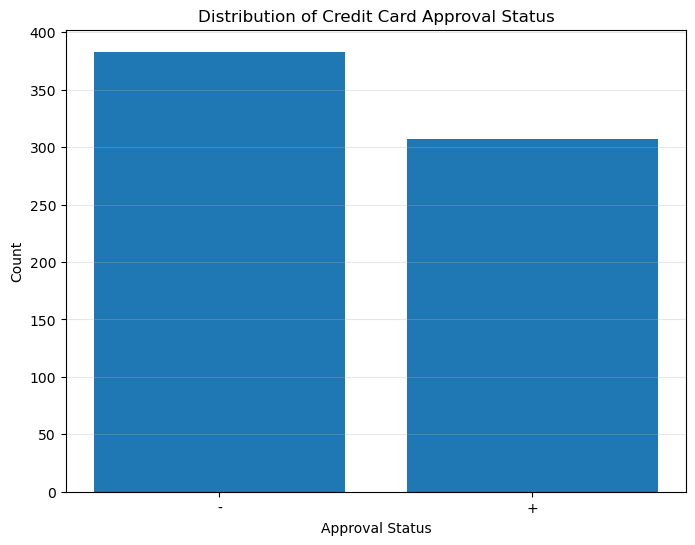

Approval rate: 44.49%
Rejection rate: 55.51%


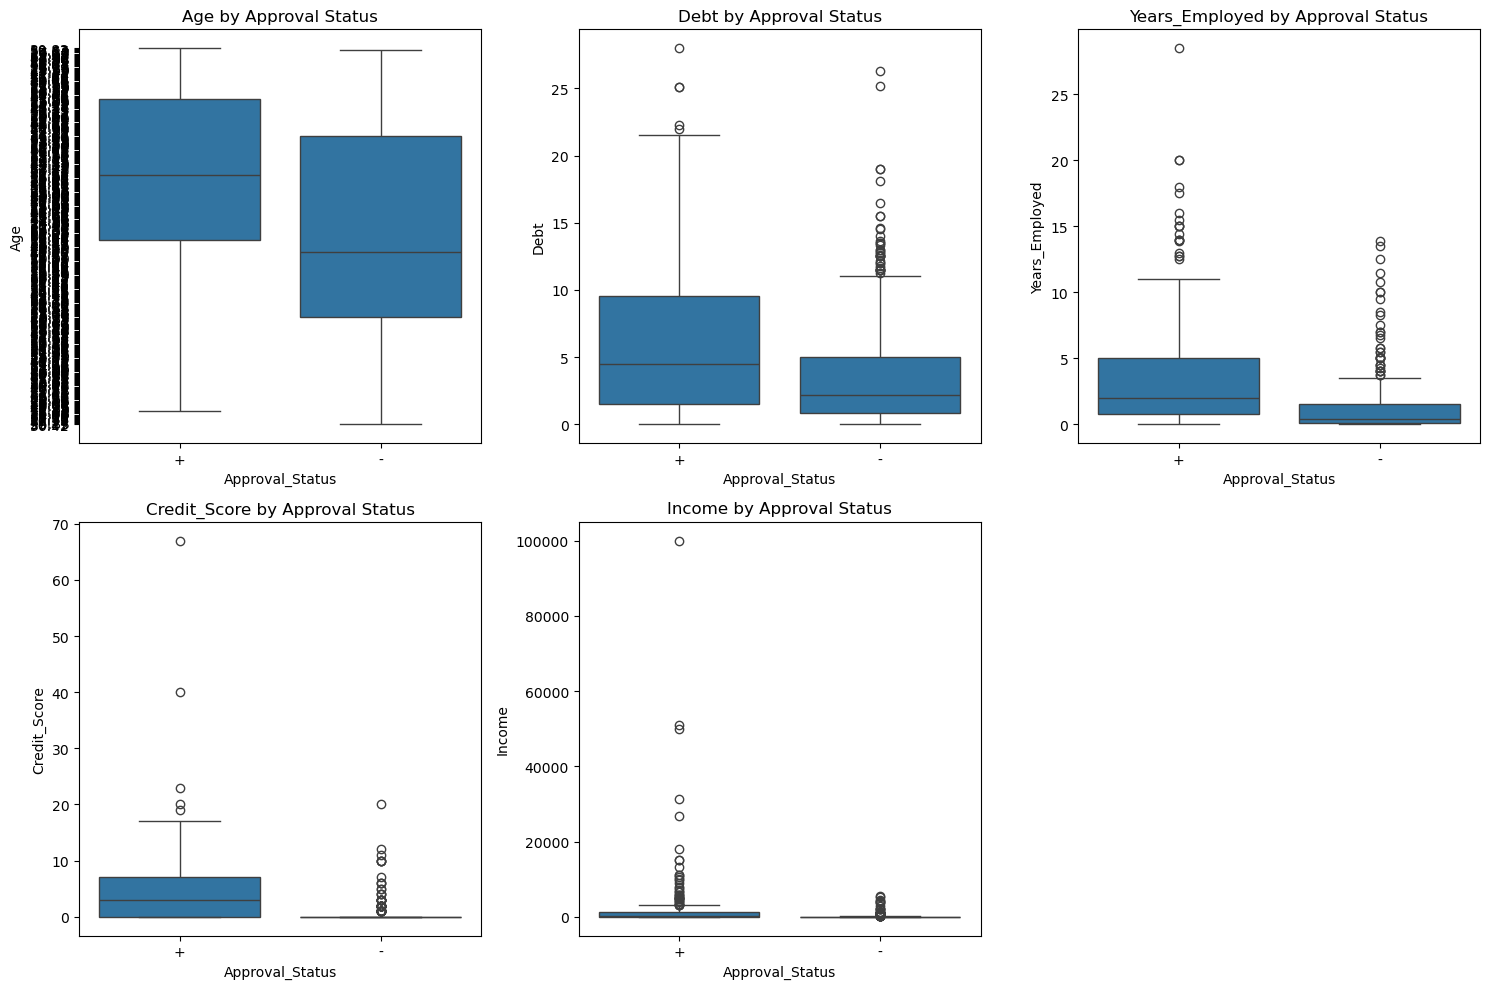

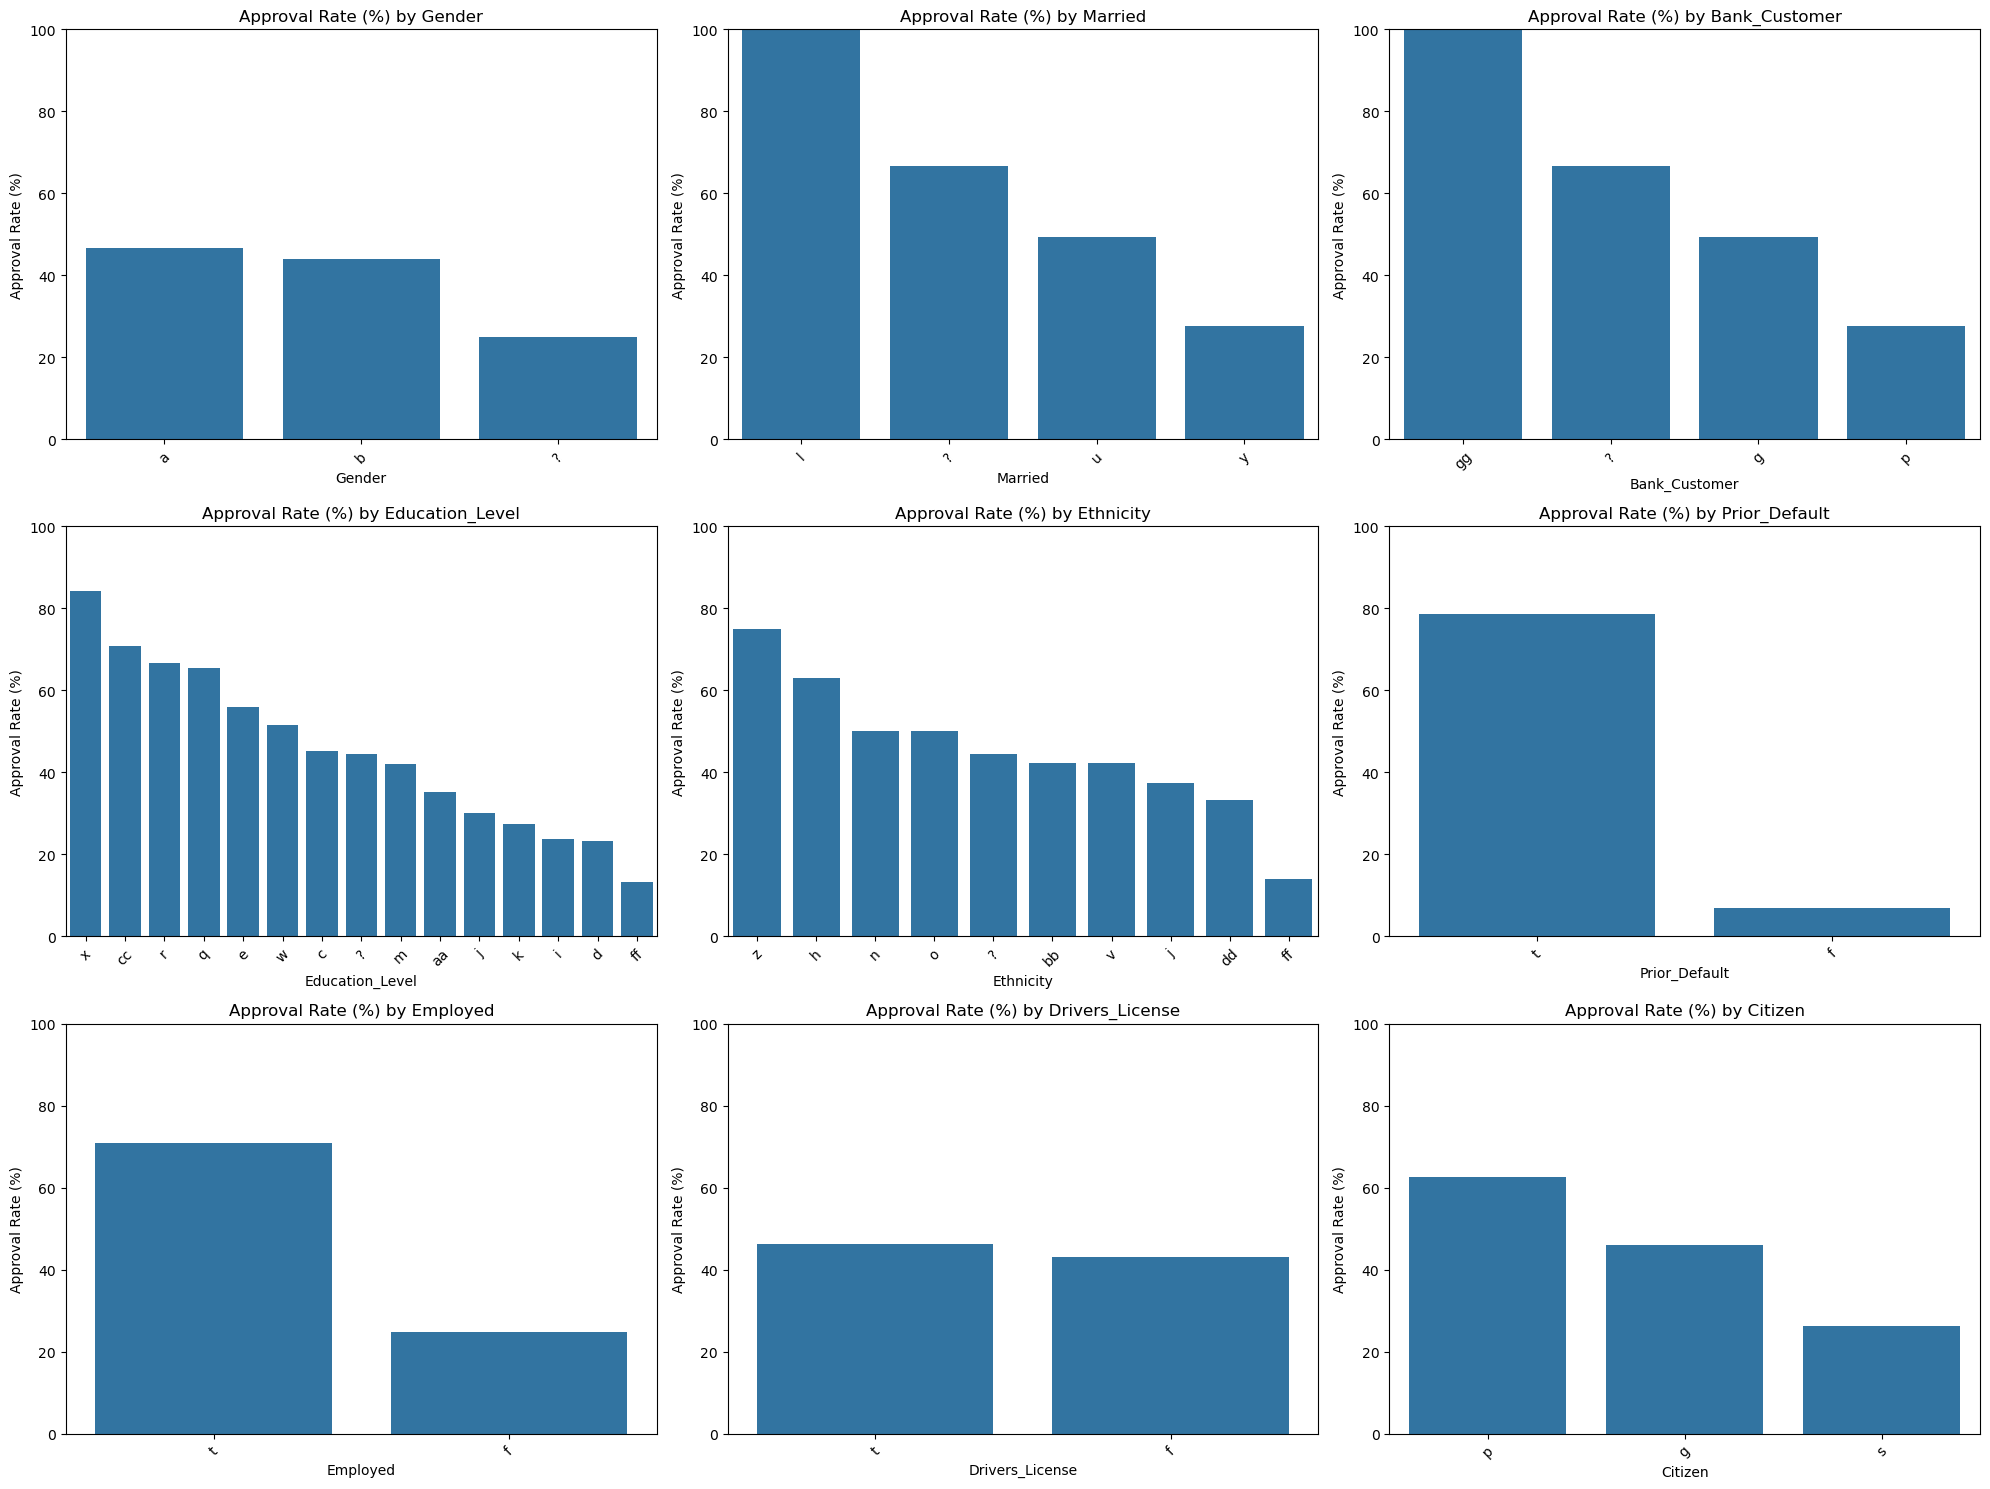

In [4]:
# Exploratory Data Analysis
# Check the distribution of the target variable
plt.figure(figsize=(8, 6))
approval_counts = cc_apps['Approval_Status'].value_counts()
plt.bar(approval_counts.index, approval_counts.values)
plt.title('Distribution of Credit Card Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Approval rate: {approval_counts['+'] / len(cc_apps) * 100:.2f}%")
print(f"Rejection rate: {approval_counts['-'] / len(cc_apps) * 100:.2f}%")

# Analyze numeric features
numeric_features = ['Age', 'Debt', 'Years_Employed', 'Credit_Score', 'Income']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Approval_Status', y=feature, data=cc_apps)
    plt.title(f'{feature} by Approval Status')
plt.tight_layout()
plt.show()

# Analyze categorical features
categorical_features = ['Gender', 'Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 
                        'Prior_Default', 'Employed', 'Drivers_License', 'Citizen']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    approval_rate = cc_apps.groupby(feature)['Approval_Status'].apply(
        lambda x: (x == '+').mean() * 100
    ).sort_values(ascending=False)
    
    sns.barplot(x=approval_rate.index, y=approval_rate.values)
    plt.title(f'Approval Rate (%) by {feature}')
    plt.ylabel('Approval Rate (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    
plt.tight_layout()
plt.show()

In [5]:
# Data Preprocessing
# Replace '?' with NaN
cc_apps = cc_apps.replace('?', np.nan)

# Separate features and target
X = cc_apps.drop('Approval_Status', axis=1)
y = cc_apps['Approval_Status']

# Convert target to binary (0 for rejected, 1 for approved)
y = y.map({'+': 1, '-': 0})

# Identify numeric and categorical columns
numeric_cols = ['Age', 'Debt', 'Years_Employed', 'Credit_Score', 'Income']
categorical_cols = X.columns.difference(numeric_cols)

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (552, 15)
Testing set shape: (138, 15)


Logistic Regression Results:
Accuracy: 0.8913

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        77
           1       0.87      0.89      0.88        61

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138



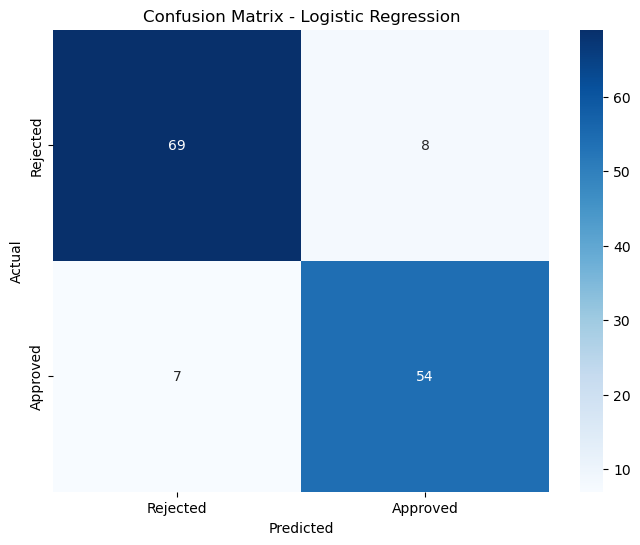

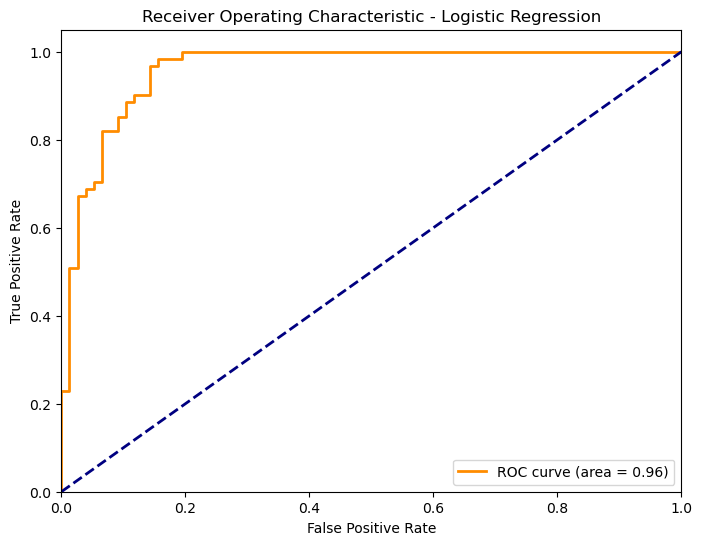


Random Forest Results:
Accuracy: 0.9130

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        77
           1       0.93      0.87      0.90        61

    accuracy                           0.91       138
   macro avg       0.92      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



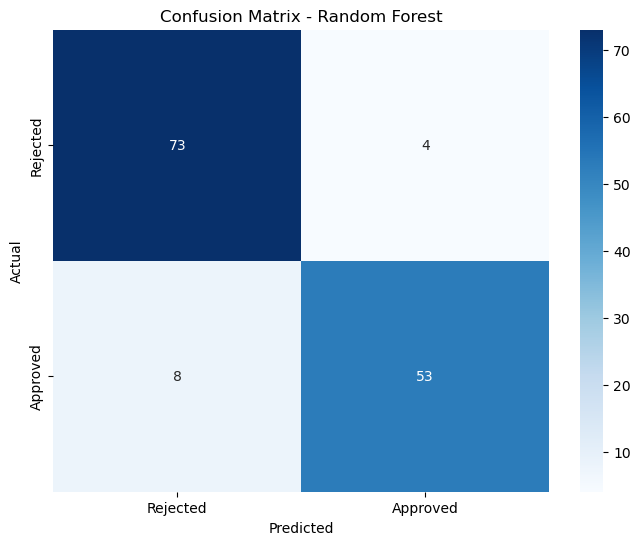

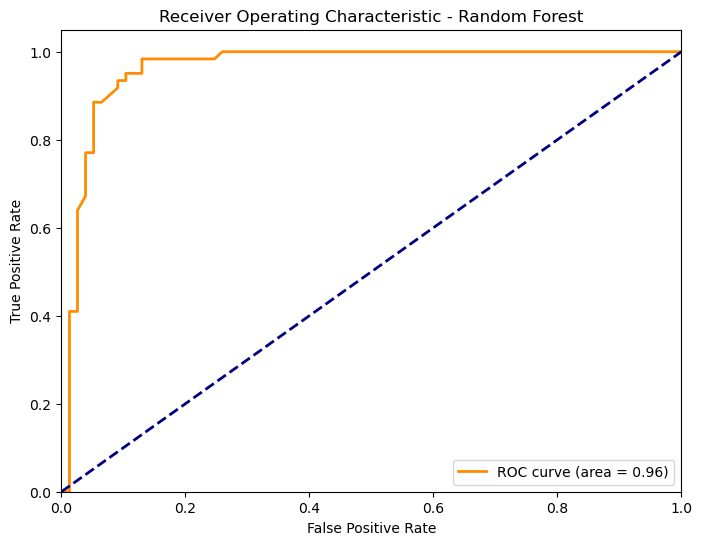

In [6]:
# Model Building and Evaluation

# 1. Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg_pipeline.predict(X_test)
y_prob_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# 2. Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

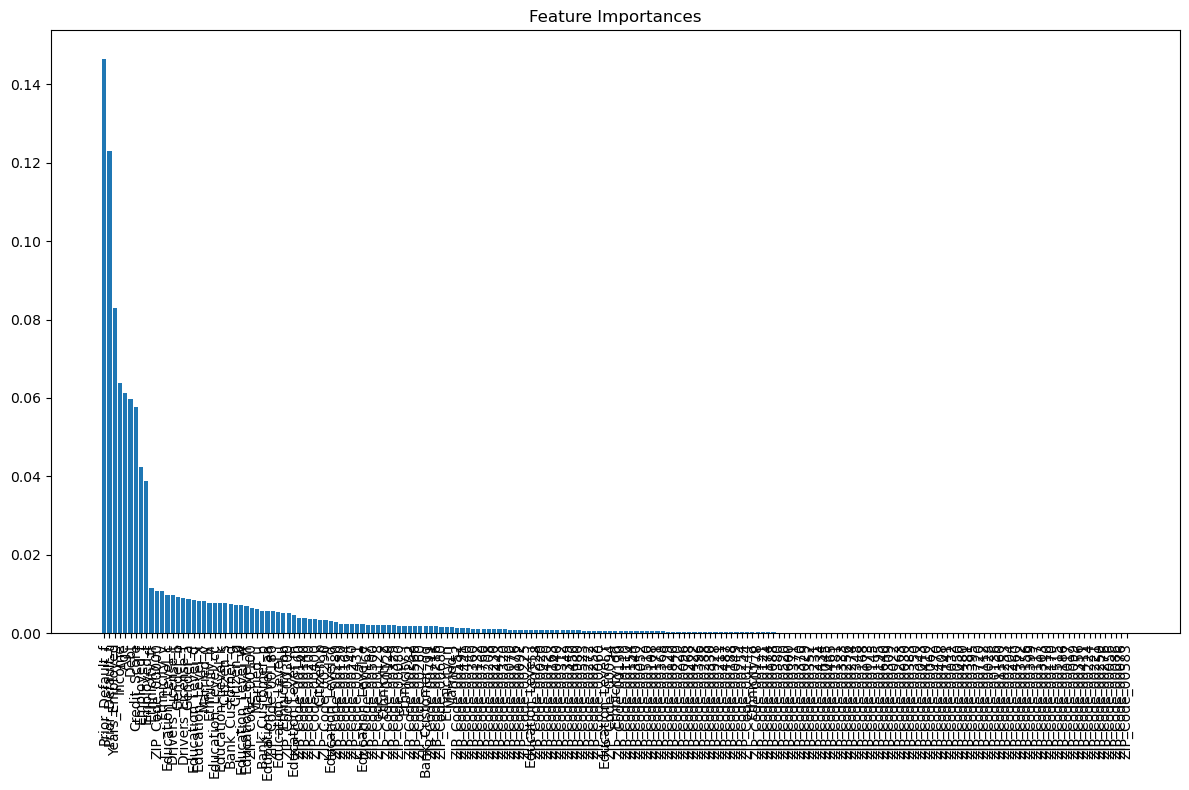

Top 10 most important features:
1. Prior_Default_f: 0.1465
2. Prior_Default_t: 0.1229
3. Years_Employed: 0.0829
4. Income: 0.0638
5. Age: 0.0612
6. Debt: 0.0597
7. Credit_Score: 0.0577
8. Employed_f: 0.0424
9. Employed_t: 0.0388
10. Ethnicity_ff: 0.0116


In [7]:
# Feature Importance Analysis
# Get feature names after preprocessing
preprocessed_X_train = preprocessor.fit_transform(X_train)
feature_names = []

# Get numeric feature names
feature_names.extend(numeric_cols)

# Get one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)

# Train a Random Forest on preprocessed data to get feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(preprocessed_X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("Top 10 most important features:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [8]:
print("Model training complete!")

Model training complete!


Performing grid search for Random Forest...
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation score: 0.8695

Best Random Forest Model Results:
Accuracy: 0.8841

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        77
           1       0.91      0.82      0.86        61

    accuracy                           0.88       138
   macro avg       0.89      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138



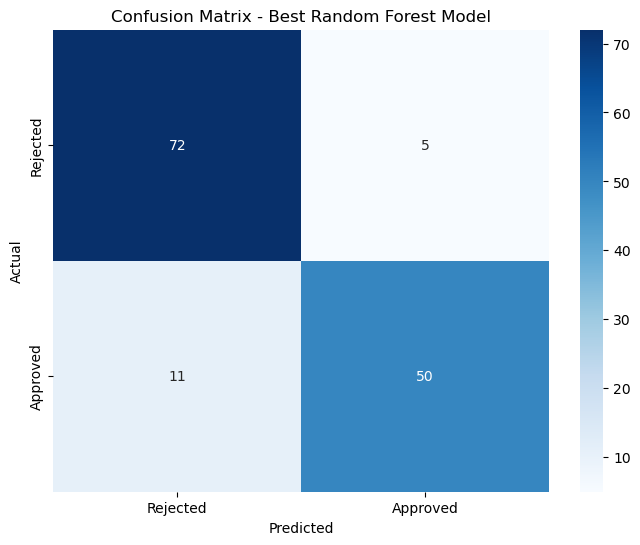

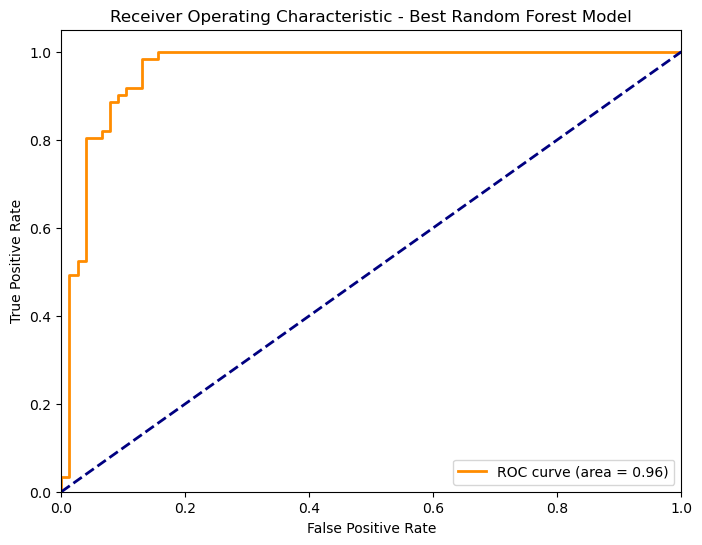

Best model saved as 'credit_card_approval_model.pkl'


In [9]:
# Hyperparameter Tuning for Random Forest
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Create the grid search
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Random Forest...")
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("\nBest Random Forest Model Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Random Forest Model')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Best Random Forest Model')
plt.legend(loc="lower right")
plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'credit_card_approval_model.pkl')
print("Best model saved as 'credit_card_approval_model.pkl'")

In [11]:
# Save the best model
import joblib
joblib.dump(best_model, 'credit_card_approval_model.pkl')
print("Best model saved as 'credit_card_approval_model.pkl'")

# Create a Gradio Dashboard to display all graphs and model predictions
import gradio as gr
import matplotlib.pyplot as plt
import io
from PIL import Image

# Function to load the saved model
def load_model():
    return joblib.load('credit_card_approval_model.pkl')

# Function to create feature importance plot
def create_feature_importance_plot():
    model = load_model()
    rf_model = model.named_steps['classifier']
    
    # Get feature names after preprocessing
    feature_names = []
    feature_names.extend(numeric_cols)
    ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_features)
    
    # Get feature importances
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    
    # Save to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# Function to create ROC curve
def create_roc_curve():
    model = load_model()
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Save to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# Function to create confusion matrix
def create_confusion_matrix():
    model = load_model()
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Save to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# Function to create approval distribution plot
def create_approval_distribution():
    plt.figure(figsize=(8, 6))
    approval_counts = cc_apps['Approval_Status'].value_counts()
    plt.bar(approval_counts.index, approval_counts.values)
    plt.title('Distribution of Credit Card Approval Status')
    plt.xlabel('Approval Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Save to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# Function to make predictions on new data
def predict_approval(age, debt, years_employed, credit_score, income, gender, married, 
                     bank_customer, education_level, ethnicity, prior_default, 
                     employed, drivers_license, citizen):
    model = load_model()
    
    # Create a dataframe with the input values
    input_data = pd.DataFrame({
        'Age': [age],
        'Debt': [debt],
        'Years_Employed': [years_employed],
        'Credit_Score': [credit_score],
        'Income': [income],
        'Gender': [gender],
        'Married': [married],
        'Bank_Customer': [bank_customer],
        'Education_Level': [education_level],
        'Ethnicity': [ethnicity],
        'Prior_Default': [prior_default],
        'Employed': [employed],
        'Drivers_License': [drivers_license],
        'Citizen': [citizen],
        'ZIP_Code': ['00000']  # Default value as it's not used in prediction
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0][1]
    
    result = "Approved" if prediction == 1 else "Rejected"
    return f"{result} (Confidence: {probability:.2f})"

# Create Gradio interface
with gr.Blocks(title="Credit Card Approval Prediction Dashboard") as dashboard:
    gr.Markdown("# Credit Card Approval Prediction Dashboard")
    
    with gr.Tab("Model Visualizations"):
        gr.Markdown("## Model Performance Visualizations")
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("### Confusion Matrix")
                confusion_matrix_plot = gr.Image(create_confusion_matrix())
            
            with gr.Column():
                gr.Markdown("### ROC Curve")
                roc_curve_plot = gr.Image(create_roc_curve())
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("### Feature Importance")
                feature_importance_plot = gr.Image(create_feature_importance_plot())
            
            with gr.Column():
                gr.Markdown("### Approval Distribution")
                approval_distribution_plot = gr.Image(create_approval_distribution())
    
    with gr.Tab("Make Predictions"):
        gr.Markdown("## Predict Credit Card Approval")
        
        with gr.Row():
            with gr.Column():
                # Numeric inputs
                age = gr.Slider(18, 100, 30, label="Age")
                debt = gr.Slider(0, 20, 2, label="Debt")
                years_employed = gr.Slider(0, 30, 5, label="Years Employed")
                credit_score = gr.Slider(0, 20, 5, label="Credit Score")
                income = gr.Slider(0, 100000, 30000, label="Income")
            
            with gr.Column():
                # Categorical inputs
                gender = gr.Dropdown(["a", "b"], label="Gender (a/b)")
                married = gr.Dropdown(["u", "y"], label="Married Status (u/y)")
                bank_customer = gr.Dropdown(["g", "p"], label="Bank Customer (g/p)")
                education_level = gr.Dropdown(["w", "q", "m", "r", "c", "k", "cc", "i", "e", "d"], 
                                             label="Education Level")
                ethnicity = gr.Dropdown(["v", "h", "bb", "j", "n", "z", "ff", "o", "dd"], 
                                       label="Ethnicity")
        
        with gr.Row():
            with gr.Column():
                prior_default = gr.Dropdown(["t", "f"], label="Prior Default (t/f)")
                employed = gr.Dropdown(["t", "f"], label="Employed (t/f)")
                drivers_license = gr.Dropdown(["t", "f"], label="Drivers License (t/f)")
                citizen = gr.Dropdown(["g", "s", "p"], label="Citizen Status")
            
            with gr.Column():
                prediction_output = gr.Textbox(label="Prediction Result")
                predict_button = gr.Button("Predict Approval")
        
        predict_button.click(
            fn=predict_approval,
            inputs=[age, debt, years_employed, credit_score, income, gender, married, 
                   bank_customer, education_level, ethnicity, prior_default, 
                   employed, drivers_license, citizen],
            outputs=prediction_output
        )
    
    with gr.Tab("About"):
        gr.Markdown("""
        ## About This Dashboard
        
        This dashboard provides an interactive interface for the Credit Card Approval Prediction model.
        
        ### Features:
        - View model performance metrics and visualizations
        - Make predictions on new applicant data
        - Explore feature importance
        
        ### Model Information:
        - Algorithm: Random Forest Classifier
        - Accuracy: {:.2f}%
        - Data source: Credit Card Approval dataset
        
        ### How to use:
        1. Explore the model visualizations in the first tab
        2. Use the prediction tab to input applicant information and get approval predictions
        """.format(accuracy_score(y_test, y_pred_best) * 100))

# Launch the Gradio interface
dashboard.launch(share=True)

Best model saved as 'credit_card_approval_model.pkl'
* Running on local URL:  http://127.0.0.1:7863

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
